In [1]:
import os
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [5]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

In [6]:
SAMPLE_RATE = 16000
FIXED_LENGTH = 4 * SAMPLE_RATE  
CANDIDATE_SOURCES = 6  

def load_audio_files(folder, sr=SAMPLE_RATE):
    audio = []
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            y, _ = librosa.load(os.path.join(folder, file), sr=sr)
            if len(y) >= FIXED_LENGTH:
                y = y[:FIXED_LENGTH]
            else:
                y = np.pad(y, (0, FIXED_LENGTH - len(y)))
            audio.append(y)
    return np.array(audio)

mixed_audio_dir = '/Users/dhanarahulsainadiminti/Library/Mobile Documents/com~apple~CloudDocs/dataset_SDP/mixed'  
mixtures = load_audio_files(mixed_audio_dir)
mixtures = mixtures[..., np.newaxis]

def create_mixture_of_mixtures(mixtures):
    np.random.shuffle(mixtures)
    half = len(mixtures) // 2
    mix1 = mixtures[:half]
    mix2 = mixtures[half:half*2]
    moms = mix1 + mix2
    return moms, mix1, mix2

mom_input, ref1, ref2 = create_mixture_of_mixtures(mixtures)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(mom_input, ref1, ref2, test_size=0.2)

def build_dynamic_mixit_model():
    inp = layers.Input(shape=(FIXED_LENGTH, 1))
    x = layers.Conv1D(256, 20, strides=10, activation='relu', padding='same')(inp)
    for _ in range(3):
        x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    separated_sources = [layers.Conv1DTranspose(1, 20, strides=10, padding='same')(x) for _ in range(CANDIDATE_SOURCES)]
    return models.Model(inputs=inp, outputs=separated_sources)

model = build_dynamic_mixit_model()


def dynamic_mixit_loss(y_trues, y_preds):
    pred_stack = tf.stack(y_preds, axis=1) 
    ref_stack = tf.stack(y_trues, axis=1)  

    def compute_loss_for_sample(inputs):
        preds_sample, refs_sample = inputs 

        combos = tf.convert_to_tensor(
            list(itertools.combinations(range(CANDIDATE_SOURCES), 2)),
            dtype=tf.int32
        ) 

        def compute_loss_for_combo(combo):
            selected_preds = tf.gather(preds_sample, combo)
            loss = tf.reduce_mean(tf.abs(selected_preds - refs_sample))
            return loss

        all_losses = tf.map_fn(compute_loss_for_combo, combos, dtype=tf.float32)
        return tf.reduce_min(all_losses)

    per_sample_losses = tf.map_fn(
        compute_loss_for_sample,
        (pred_stack, ref_stack),
        dtype=tf.float32
    )

    return tf.reduce_mean(per_sample_losses)
    
class DynamicMixITTrainer(tf.keras.Model):
    def __init__(self, base_model):
        super(DynamicMixITTrainer, self).__init__()
        self.base_model = base_model

    def compile(self, optimizer):
        super(DynamicMixITTrainer, self).compile()
        self.optimizer = optimizer
        self.train_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

    @property
    def metrics(self):
        return [self.train_loss_tracker, self.val_loss_tracker]

    def train_step(self, data):
        x, y = data 
        with tf.GradientTape() as tape:
            y_preds = self.base_model(x, training=True) 
            loss = dynamic_mixit_loss(y, y_preds)

        grads = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))
        self.train_loss_tracker.update_state(loss)
        return {"loss": self.train_loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_preds = self.base_model(x, training=False)
        loss = dynamic_mixit_loss(y, y_preds)
        self.val_loss_tracker.update_state(loss)
        return {"val_loss": self.val_loss_tracker.result()}


mixit_trainer = DynamicMixITTrainer(model)
mixit_trainer.compile(optimizer=tf.keras.optimizers.Adam(1e-4))    

Epoch 1/30
Instructions for updating:
Use fn_output_signature instead
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 713ms/step - loss: 0.1232 - val_val_loss: 0.0907
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 748ms/step - loss: 0.0891 - val_val_loss: 0.0863
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 774ms/step - loss: 0.0838 - val_val_loss: 0.0841
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 768ms/step - loss: 0.0833 - val_val_loss: 0.0828
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 776ms/step - loss: 0.0800 - val_val_loss: 0.0807
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - loss: 0.0796 - val_val_loss: 0.0798
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 975ms/step - loss: 0.0784 - val_val_loss: 0.0781
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 963ms/step - loss: 0.0767 - val_val_loss: 0.0776
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 904ms/step - loss: 0.0757 - val_val_loss: 0.0775
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 899ms/step - loss: 0.0764 - val_val_loss: 0.0770
Epoch 11/30
50/50 ━━━━━━━━━━━━

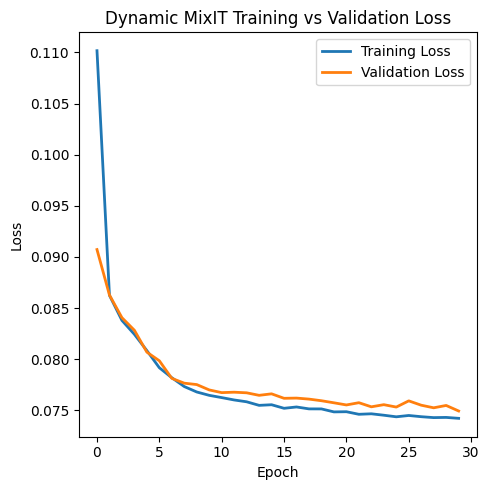

In [7]:
history = mixit_trainer.fit(
    x=X_train, y=(y1_train, y2_train),
    validation_data=(X_val, (y1_val, y2_val)),
    epochs=30,
    batch_size=8
)


model.save("dynamic_mixit_model.h5")


plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_val_loss'], label='Validation Loss', linewidth=2)
plt.title("Dynamic MixIT Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
SAMPLE_RATE = 16000
FIXED_LENGTH = 4 * SAMPLE_RATE  
MODEL_PATH = "dynamic_mixit_model.h5"
CANDIDATE_SOURCES = 6
ENERGY_THRESHOLD = 0.01  

model = tf.keras.models.load_model(MODEL_PATH, compile=False)


def load_and_preprocess_audio(filepath):
    y, _ = librosa.load(filepath, sr=SAMPLE_RATE)
    if len(y) >= FIXED_LENGTH:
        y = y[:FIXED_LENGTH]
    else:
        y = np.pad(y, (0, FIXED_LENGTH - len(y)))
    return y[np.newaxis, ..., np.newaxis]  # (1, T, 1)


def estimate_sources_energy(pred_sources):
    sources = pred_sources.numpy().squeeze()  # (K, T)
    energies = np.sum(np.abs(sources), axis=1) / sources.shape[1]
    valid = energies > ENERGY_THRESHOLD
    return sources[valid], energies


def estimate_sources_cluster(pred_sources, max_components=10):
    sources = pred_sources.numpy().squeeze()  # (K, T)
    K, T = sources.shape

    n_components = min(K, max_components)
    pca = PCA(n_components=n_components)
    embeddings = pca.fit_transform(sources)  # (K, n_components)

    cluster_range = range(2, min(K, 6))  # try 2 to 5 clusters max
    scores = []
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
        scores.append(kmeans.inertia_)

    deltas = np.diff(scores)
    est_clusters = cluster_range[np.argmin(deltas)] if len(deltas) else 2

    kmeans = KMeans(n_clusters=est_clusters, random_state=42).fit(embeddings)
    selected_sources = []
    for i in range(est_clusters):
        cluster_members = sources[kmeans.labels_ == i]
        mean_source = np.mean(cluster_members, axis=0)
        selected_sources.append(mean_source)
    return np.stack(selected_sources), scores



def save_sources(sources, output_dir, base_name="source"):
    os.makedirs(output_dir, exist_ok=True)
    for i, s in enumerate(sources):
        out_path = os.path.join(output_dir, f"{base_name}_{i+1}.wav")
        sf.write(out_path, s, SAMPLE_RATE)
        print(f"Saved: {out_path}")


def separate_sources(input_wav_path, mode="energy", output_dir="separated_outputs"):
    x = load_and_preprocess_audio(input_wav_path)
    pred_sources = model(x) 

    pred_sources = tf.concat(pred_sources, axis=-1)  
    pred_sources = tf.transpose(pred_sources, perm=[0, 2, 1])  
    
    if mode == "energy":
        selected, _ = estimate_sources_energy(pred_sources)
        print(f"[Energy] Selected {selected.shape[0]} sources.")
    elif mode == "cluster":
        selected, _ = estimate_sources_cluster(pred_sources)
        print(f"[Clustering] Selected {selected.shape[0]} sources.")
    else:
        raise ValueError("mode must be either 'energy' or 'cluster'")
    
    save_sources(selected, output_dir)


if __name__ == "__main__":
    test_wav = '/Users/dhanarahulsainadiminti/Library/Mobile Documents/com~apple~CloudDocs/dataset_SDP/Bio/segmented/87004ch4 44kHz_chunk_274.wav'  # <-- Replace with your input .wav
    separate_sources(test_wav, mode="energy", output_dir="out_energy")
    separate_sources(test_wav, mode="cluster", output_dir="out_cluster")


[Energy] Selected 4 sources.
Saved: out_energy/source_1.wav
Saved: out_energy/source_2.wav
Saved: out_energy/source_3.wav
Saved: out_energy/source_4.wav
[Clustering] Selected 3 sources.
Saved: out_cluster/source_1.wav
Saved: out_cluster/source_2.wav
Saved: out_cluster/source_3.wav
